# BERT Training

BERT is a pretrained NLP vectorization model. 

However, since I am wanting to use it for sentiment analysis, I need to add a classifier on top. 

This implementation will be used to calculate the sentiment (pos/neut/neg) on a corpus of newspaper articles.

Unfortunately, I couldn't find any news articles that had already been labeled, so I'm going to train the classifier with data from Reddit and Twitter.copyright

Not ideal, but it will be closer than training it on IMDB reviews or something

In [10]:
# background stuff
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

# tf stuff
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# just because I like bringing in files this way
from tkinter import Tk
from tkinter import filedialog as fd

# For plotting
from matplotlib import pyplot as plt


# try out AdamW


### Load in the bert models

In [2]:
# let's start with small bert, just to make it a little more manageable
bert_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
prep_handle = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

prep_model = hub.KerasLayer(prep_handle)
bert_model = hub.KerasLayer(bert_handle)

### Load in the training data

This will (unfortunately) just be the Reddit and Twitter positive and negative data. So it goes

In [11]:
root = Tk()
filename = fd.askopenfilename(master=root, filetypes=[('see ess vee','*.csv')])
root.destroy()

reddit_df = pd.read_csv(filename)
# reddit_df['category'] = (reddit_df['category']+1)/2
train_df,test_df = train_test_split(reddit_df, train_size=.8)

### Define the classifier model
Setting up the graph so that data is coming from the text preprocessing layer, through the BERT model, and finally into the classifier.

For now the classifier is just a single unit dense layer that brings in everything from the 'pooled output' of BERT

In [12]:
# from tensorflow's tutorial
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    prep_layer = hub.KerasLayer(prep_handle)
    encoder_inputs = prep_layer(text_input)
    encoder = hub.KerasLayer(bert_handle)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='softsign', name='classifier')(net)
    return tf.keras.Model(text_input, net)

### Initialize and fit model

In [13]:
classifier_model = build_classifier_model()

# classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'mse')


# setup the fit
classifier_model.fit(x = train_df['text'].to_numpy().astype(str), y=train_df['category'].to_numpy(), epochs=4)

KeyError: 'clean_comment'

### Predict the testing dataset

how bad did we do?

In [7]:
pred_train = classifier_model.predict(train_df.text.to_numpy().astype(str))
pred_test = classifier_model.predict(test_df.text.to_numpy().astype(str))

# if we're treating the classification as a continuous variable from neg (-1) to pos (1) with neutral being 0
print(f"Testing dataset MSE: {metrics.mean_squared_error(test_df['category'].to_numpy(), pred_test)}")

# # use this if we're treating Pos/Neut/Neg as three separate classes
# print(f"Testing dataset accuracy: {metrics.accuracy_score(test_df['category'].to_numpy(), predicts)}")

233/233 [==============================] - 20s 87ms/step
Testing dataset MSE: 0.5370259392856596


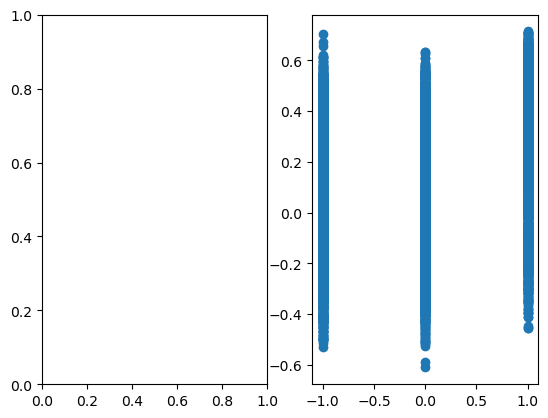

In [8]:
fig,ax = plt.subplots(ncols=2)

# Train dataset 
# ax[0].scatter(train_df['category'], )
# Test dataset
ax[1].scatter(test_df['category'], predicts)

### Clear everything

*WARNING* only run this section if you're wanting to remove the graph and the session.

This is because I have been having some issues with early stopping in training subsequent models, so I want to see if this fixes it

In [9]:
tf.keras.backend.clear_session()